# Importing necessary Libraries

In [ ]:
!pip install yfinance

In [ ]:
!pip install yahoo_fin

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from scipy.fft import fft, ifft

# Defining Parameters and Fetching Historical Data

In [ ]:
tickers = [
    "ACN", "ADBE", "AMD", "AKAM", "APH", "TRMB", "TYL", "VRSN", "WDC", "ZBRA",
    "GOOGL", "AMZN", "AAPL", "MSFT", "META", "TSLA", "NFLX", "NVDA", "INTC"
]

historical_data = {}

for ticker in tickers:
    stock = yf.Ticker(ticker)
    try:
        historical_data[ticker] = stock.history(period="2y")['Close']
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

close_prices = pd.DataFrame(historical_data)


# Data Preprocessing

In [ ]:
close_prices.fillna(method='ffill', inplace=True)
close_prices.dropna(inplace=True)

# Apply DFT to each time series
dft_data = {ticker: fft(close_prices[ticker].to_numpy()) for ticker in close_prices.columns}

# Identifying Cointegrated Pairs

Cointegrated Pairs:  [('ACN', 'AKAM'), ('ACN', 'INTC'), ('ADBE', 'INTC'), ('AMD', 'TYL'), ('AMD', 'MSFT'), ('AMD', 'META'), ('AKAM', 'INTC'), ('APH', 'WDC'), ('APH', 'NVDA'), ('TRMB', 'VRSN'), ('TYL', 'WDC'), ('TYL', 'GOOGL'), ('TYL', 'AMZN'), ('TYL', 'AAPL'), ('TYL', 'MSFT'), ('TYL', 'META'), ('TYL', 'NFLX'), ('TYL', 'NVDA'), ('VRSN', 'WDC'), ('VRSN', 'MSFT'), ('VRSN', 'NFLX'), ('VRSN', 'INTC'), ('ZBRA', 'INTC'), ('GOOGL', 'MSFT'), ('MSFT', 'META'), ('META', 'NFLX')]


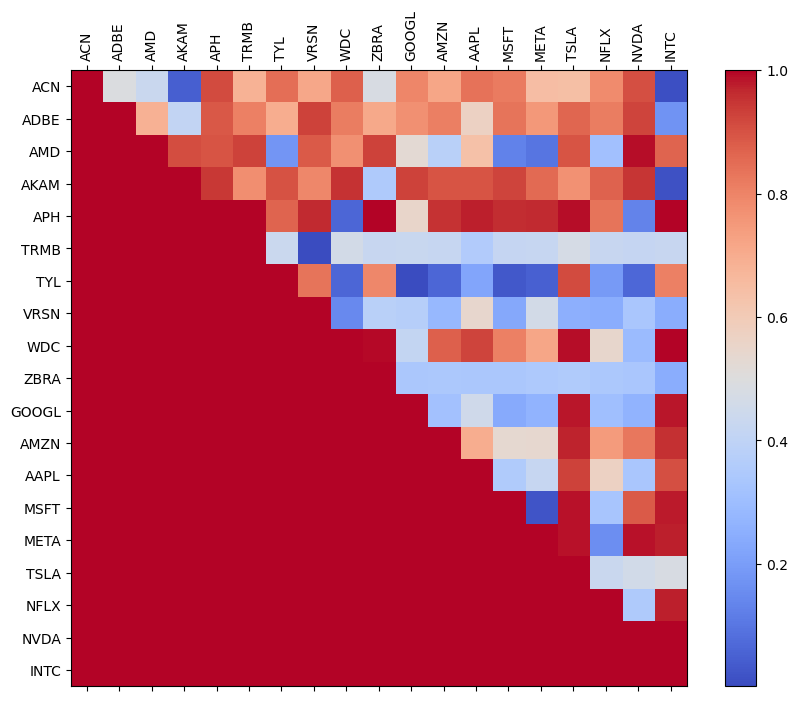

In [ ]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.columns
    pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.25:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

dft_close_prices = pd.DataFrame({ticker: ifft(dft_data[ticker]).real for ticker in dft_data})
pvalues, pairs = find_cointegrated_pairs(dft_close_prices)
print("Cointegrated Pairs: ", pairs)

fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(pvalues, cmap='coolwarm')
fig.colorbar(cax)
ax.set_xticks(np.arange(len(close_prices.columns)))
ax.set_yticks(np.arange(len(close_prices.columns)))
ax.set_xticklabels(close_prices.columns, rotation=90)
ax.set_yticklabels(close_prices.columns)
plt.show()

# Backtesting the Pairs Trading Strategy

In [ ]:
def backtest_pairs_strategy(pair, data):
    stock1, stock2 = pair
    spread = data[stock1] - data[stock2]
    zscore = (spread - spread.mean()) / spread.std()

    entry_threshold = 2
    exit_threshold = 0

    signals = pd.DataFrame(index=data.index)
    signals['spread'] = spread
    signals['zscore'] = zscore
    signals['long'] = (signals['zscore'] < -entry_threshold).astype(int)
    signals['short'] = (signals['zscore'] > entry_threshold).astype(int)
    signals['exit'] = (np.abs(signals['zscore']) < exit_threshold).astype(int)

    signals['positions1'] = signals['long'] - signals['short']
    signals['positions2'] = -signals['positions1']

    signals['positions1'] = signals['positions1'].replace(to_replace=0, method='ffill')
    signals['positions2'] = signals['positions2'].replace(to_replace=0, method='ffill')
    signals['positions1'] = signals['positions1'] * (1 - signals['exit'])
    signals['positions2'] = signals['positions2'] * (1 - signals['exit'])

    daily_returns = (data[stock1].pct_change() * signals['positions1'].shift()).fillna(0) - (data[stock2].pct_change() * signals['positions2'].shift()).fillna(0)

    cumulative_returns = (1 + daily_returns).cumprod() - 1

    # Performance metrics
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if  daily_returns.std() != 0 else np.nan
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max).min()
    win_rate = (daily_returns > 0).mean()

    metrics = {
        'cumulative_returns': cumulative_returns[-1],
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': drawdown,
        'win_rate': win_rate
    }

    return metrics, cumulative_returns, signals


# Evaluating Performance and Metrics

In [ ]:
best_pair = None
best_metrics = None
best_cumulative_returns = None
best_signals = None

for pair in pairs:
    metrics, cumulative_returns, signals = backtest_pairs_strategy(pair, close_prices)
    if best_metrics is None or (metrics['sharpe_ratio'] is not np.nan and metrics['sharpe_ratio'] > best_metrics['sharpe_ratio']):
        best_pair = pair
        best_metrics = metrics
        best_cumulative_returns = cumulative_returns
        best_signals = signals

# Print the best performing pair and its metrics
print("Best Performing Pair: ", best_pair)
print("Performance Metrics: ")
print ("Cumulative Returns: ", best_metrics['cumulative_returns'])
print ("Annualized Volatility: ", best_metrics['annualized_volatility'])
print ("Sharpe Ratio: ", best_metrics['sharpe_ratio'])
print ("Max Drawdown: ", best_metrics['max_drawdown'])
print ("Win Rate: ", best_metrics['win_rate'])

Best Performing Pair:  ('AKAM', 'INTC')
Performance Metrics: 
Cumulative Returns:  3.913580498611366
Annualized Volatility:  0.3933848741159557
Sharpe Ratio:  2.229787039269305
Max Drawdown:  -0.630652111073922
Win Rate:  0.3605577689243028


# Plotting Spread

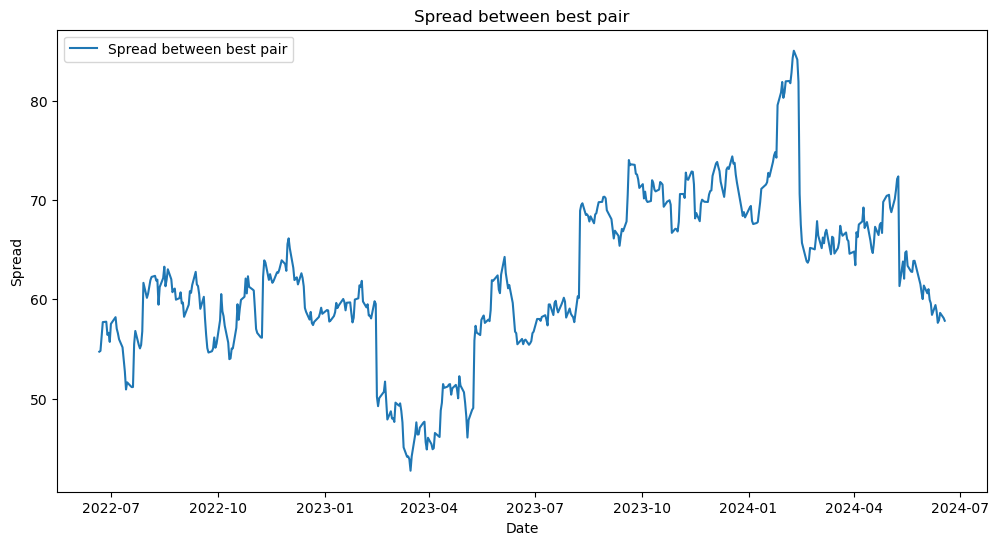

In [ ]:
plt.figure(figsize=(12, 6))
asset1, asset2 = best_pair;
spread = historical_data[asset1] - historical_data[asset2]
plt.plot(spread, label='Spread between best pair')
plt.legend()
plt.title("Spread between best pair")
plt.xlabel('Date')
plt.ylabel('Spread')
plt.show()

# Plotting Z-score

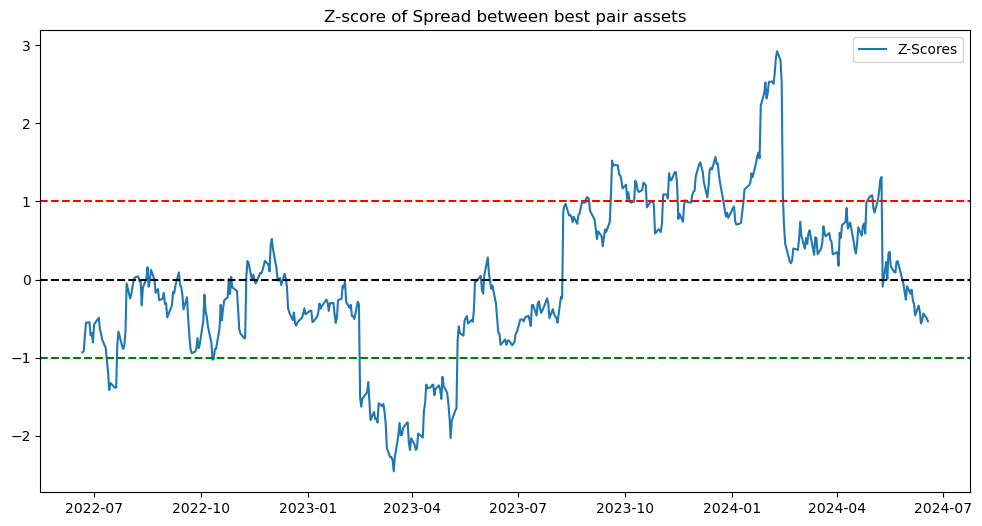

In [ ]:
zscore = (spread - spread.mean()) / spread.std()
plt.figure(figsize=(12, 6))
plt.plot(zscore, label='Z-Scores')
plt.axhline(0, color='black', linestyle='--')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend()
plt.title('Z-score of Spread between best pair assets')
plt.show()

# Plotting Trading Signals

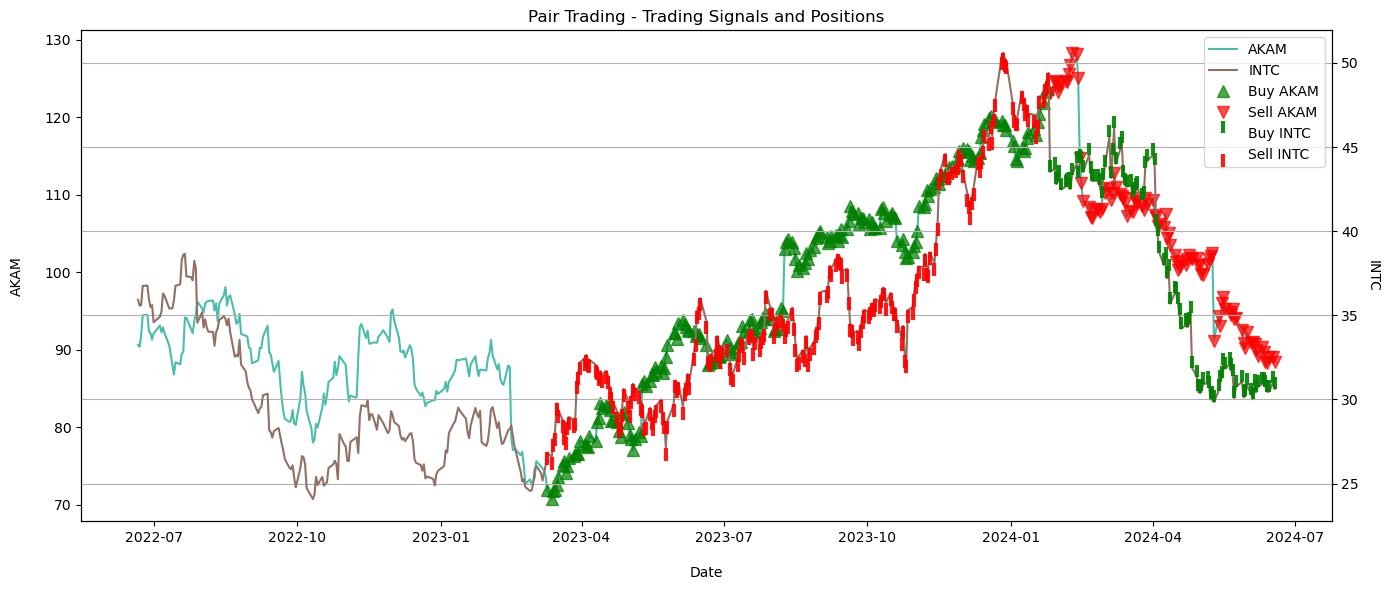

In [ ]:
asset1, asset2 = best_pair

fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)
bx2 = bx.twinx()

l1, = bx.plot(close_prices[asset1], c='#4abdac', label=asset1)
l2, = bx2.plot(close_prices[asset2], c='#907163', label=asset2)

# Plotting the buy and sell signals
u1, = bx.plot(close_prices[asset1][best_signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g', alpha=0.7, label=f'Buy {asset1}')
d1, = bx.plot(close_prices[asset1][best_signals['positions1'] == -1], lw=0, marker='v', markersize=8, c='r', alpha=0.7, label=f'Sell {asset1}')
u2, = bx2.plot(close_prices[asset2][best_signals['positions2'] == 1], lw=0, marker=2, markersize=9, c='g', alpha=0.9, markeredgewidth=3, label=f'Buy {asset2}')
d2, = bx2.plot(close_prices[asset2][best_signals['positions2'] == -1], lw=0, marker=3, markersize=9, c='r', alpha=0.9, markeredgewidth=3, label=f'Sell {asset2}')

bx.set_ylabel(asset1)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad = 15
bx2.yaxis.labelpad = 15
bx.set_xlabel('Date')
bx.xaxis.labelpad = 15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'Buy {}'.format(asset1),
           'Sell {}'.format(asset1),
           'Buy {}'.format(asset2),
           'Sell {}'.format(asset2)], loc ='best')
plt.title('Pair Trading - Trading Signals and Positions')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting Cumulative Returns

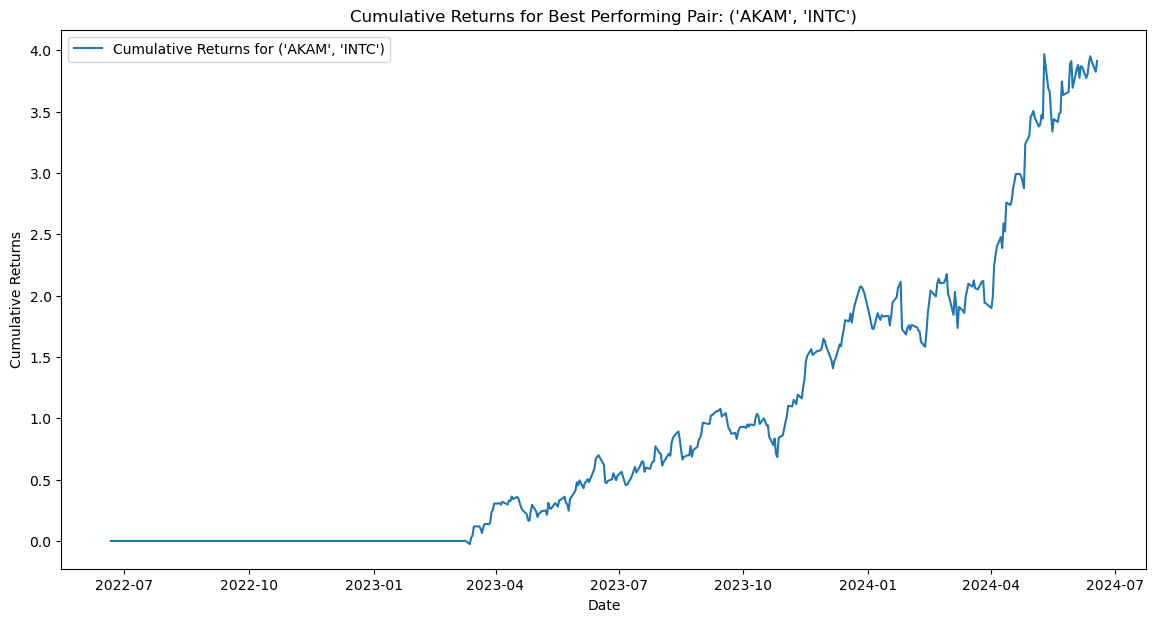

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(best_cumulative_returns, label=f'Cumulative Returns for {best_pair}')
plt.title(f'Cumulative Returns for Best Performing Pair: {best_pair}')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()